In [15]:
%load_ext autoreload
%autoreload 2
import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pickle
from tqdm import trange
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
try:
  from helpers import get_model_size, estimate_loss, normalize_tensor
except ModuleNotFoundError:
  import sys
  sys.path.append("../")
  from helpers import get_model_size, estimate_loss, normalize_tensor

torch.manual_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class CiFaData(Dataset):
  def __init__(self, stage="train", transform=None, device="cpu"):
    self.device = device
    self.base_folder = "cifar-10-batches-py"
    self.transform = transform
    if stage == "train":
      batch_collection = [f"data_batch_{i}" for i in range(1, 5)]
    elif stage == "val":
      batch_collection = ["data_batch_5"]
    elif stage == "test":
      batch_collection = ["test_batch"]
    else:
      raise ValueError("Invalid stage, choose from train, val, test.")
    self.x_data = []
    self.y_data = []
    for batch in batch_collection:
      with open(f"../data/cifar-10-batches-py/{batch}", "rb") as f:
        data = pickle.load(f, encoding="latin1") 
        self.x_data.extend(data["data"])
        self.y_data.extend(data["labels"])
    self.y_data = torch.tensor(self.y_data, device=self.device)
    self.x_data = normalize_tensor(torch.tensor(np.vstack(self.x_data).reshape(-1, 3, 32, 32), device=self.device)) # from list to vstack; results in (N, 3, 32, 32)
  def __len__(self):
    return self.y_data.shape[0]
  def __getitem__(self, idx):
    if self.transform:
      return self.transform(self.x_data[idx]), self.y_data[idx]
    return self.x_data[idx], self.y_data[idx]

In [3]:
tf = transforms.RandomRotation(degrees=(0, 180))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_ds = CiFaData(stage="train", device=device, transform=tf)
val_ds = CiFaData(stage="val", device=device)
test_ds = CiFaData(stage="test", device=device)

# pinning memory, takes cpu data and pins it to the gpu. meaning if I already 
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True) 
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

ResNet 18

In [8]:
class SubBlock(nn.Module):
  def __init__(self, inchannels, outchannels, stride, kernelsize=3, padding=1):
    super().__init__()
    self.block = nn.Sequential(
      nn.Conv2d(in_channels=inchannels, out_channels=outchannels, kernel_size=kernelsize, padding=padding, stride=stride),
      nn.BatchNorm2d(outchannels, momentum=0.01),
      nn.ReLU(),
      nn.Conv2d(in_channels=outchannels, out_channels=outchannels, kernel_size=kernelsize, padding=padding, stride=1),
      nn.BatchNorm2d(outchannels)
    )
  def forward(self, x):
    return self.block(x)
  
class ResBlock(nn.Module):
  def __init__(self, inchannels, outchannels, stride):
    super().__init__()
    self.block = nn.Sequential(
      SubBlock(inchannels, outchannels, stride),
      SubBlock(outchannels, outchannels, stride=1)
    )
  def forward(self, x):
    return self.block(x)

In [12]:
class ResNet18(nn.Module):
  def __init__(self):
    super().__init__()
    self.block0 = nn.Sequential(
      nn.Conv2d(in_channels=3, kernel_size=7, out_channels=64, stride=2, padding=3), 
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    )
    self.block1 = ResBlock(64, 64, stride=1)
    self.relu1 = nn.ReLU() 
    self.match_dim2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=2)
    self.block2 = ResBlock(64,128, stride=2)
    self.relu2 = nn.ReLU()
    self.match_dim3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, stride=2)
    self.block3 = ResBlock(128, 256, stride=2)
    self.relu3 = nn.ReLU()
    self.match_dim4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, stride=2)
    self.block4 = ResBlock(256, 512, stride=2)
    self.relu4 = nn.ReLU()
    self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512, 10)
  def forward(self, x):
    # ---------- Block0 ---------- 
    x_skip = self.block0(x)
    # ---------- Block1 ---------- 
    x = self.block1(x_skip)
    x = self.relu1(x+x_skip)
    # ---------- Block2 ---------- 
    x_skip = self.match_dim2(x)
    x = self.block2(x)
    x = self.relu2(x+x_skip)
    # ---------- Block3 ---------- 
    x_skip = self.match_dim3(x)
    x = self.block3(x)
    x = self.relu3(x+x_skip)
    # ---------- Block4 ---------- 
    x_skip = self.match_dim4(x)
    x = self.block4(x)
    x = self.relu4(x+x_skip)
    # ---------- Linear ----------
    x = self.avg_pool(x)
    x = torch.flatten(x, start_dim=1)
    return self.fc(x)

In [13]:
epochs = 100
lr = 1e-5
res18 = ResNet18()
res18.to(device)

# optimizer = optim.SGD(params=[p for p in res18.parameters() if p.requires_grad == True], momentum=0.9, lr=0.05)
optimizer = optim.AdamW(params=[p for p in res18.parameters() if p.requires_grad==True], lr=lr, weight_decay=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', patience=1)
criterion = nn.CrossEntropyLoss()

model_size = get_model_size(res18)

model size: 42.696 MB


In [19]:
model = NeuralNetClassifier(module=res18, max_epochs=400, batch_size=128)
print(model.initialize())

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ResNet18(
    (block0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (block1): ResBlock(
      (block): Sequential(
        (0): SubBlock(
          (block): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): SubBlock(
          (block): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3

In [20]:
param_grid = {
  'learning_rate': [0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03]
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
result = grid.fit(val_loader)

TypeError: Singleton array array(<torch.utils.data.dataloader.DataLoader object at 0x7fcf215b22d0>,
      dtype=object) cannot be considered a valid collection.

In [ ]:
# training loop
losses = []
raw_losses = []
val_losses = []

for i in (t:=trange(epochs)):
  epoch_loss = []
  for step, (x, y) in enumerate(train_loader):
    predictions = res18(x)
    loss = criterion(predictions, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    raw_losses.append(loss.item())
    epoch_loss.append(loss.item())

  # only one per iteration
  losses.append(np.mean(epoch_loss))
  val_losses.append(estimate_loss(res18, val_loader, criterion))
  scheduler.step(metrics=val_losses[-1])
  t.set_description(f"epoch {i+1} | training loss: {losses[-1]:.4f} | validation loss: {val_losses[-1]:.4f} | current lr: {optimizer.param_groups[0]['lr']}")
  
test_loss = estimate_loss(res18, test_loader, criterion) 
print(f'final test loss is : {test_loss}')

  0%|          | 0/100 [00:00<?, ?it/s]

epoch 100 | training loss: 1.0704 | validation loss: 1.4332 | current lr: 1.0000000000000004e-08: 100%|██████████| 100/100 [25:35<00:00, 15.36s/it]

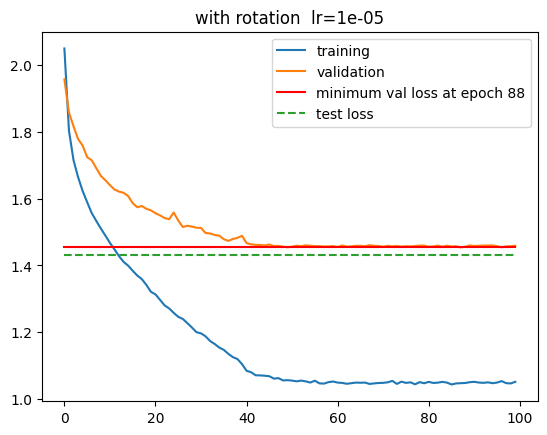

In [ ]:
plt.figure()
plt.title(f'with rotation  lr={lr}')
plt.plot(range(epochs), losses, label='training')
plt.plot(range(epochs), val_losses, label='validation')
plt.plot(range(epochs), [np.min(val_losses)]*epochs, color='r', label=f'minimum val loss at epoch {np.argmin(val_losses)+1}')
plt.plot(range(epochs), [test_loss]*epochs, linestyle='dashed', label='test loss')
plt.legend()
plt.show()